In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'src')))
from classical.FactorsModelOLS import FactorsModelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Loading Data

In [2]:
assets_path = r'../../data/100 close prices 5Y.csv'
market_path = r'../../data/spy close 5y.csv'

In [3]:
close = pd.read_csv(assets_path).set_index('date').dropna().iloc[:-1]
spy = pd.read_csv(market_path).set_index('Date')

In [4]:
y = close['GOOGL']

# Creating and Preprocessing Features

In [5]:
sma5 = y.rolling(5).mean()
sma10 = y.rolling(10).mean()

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


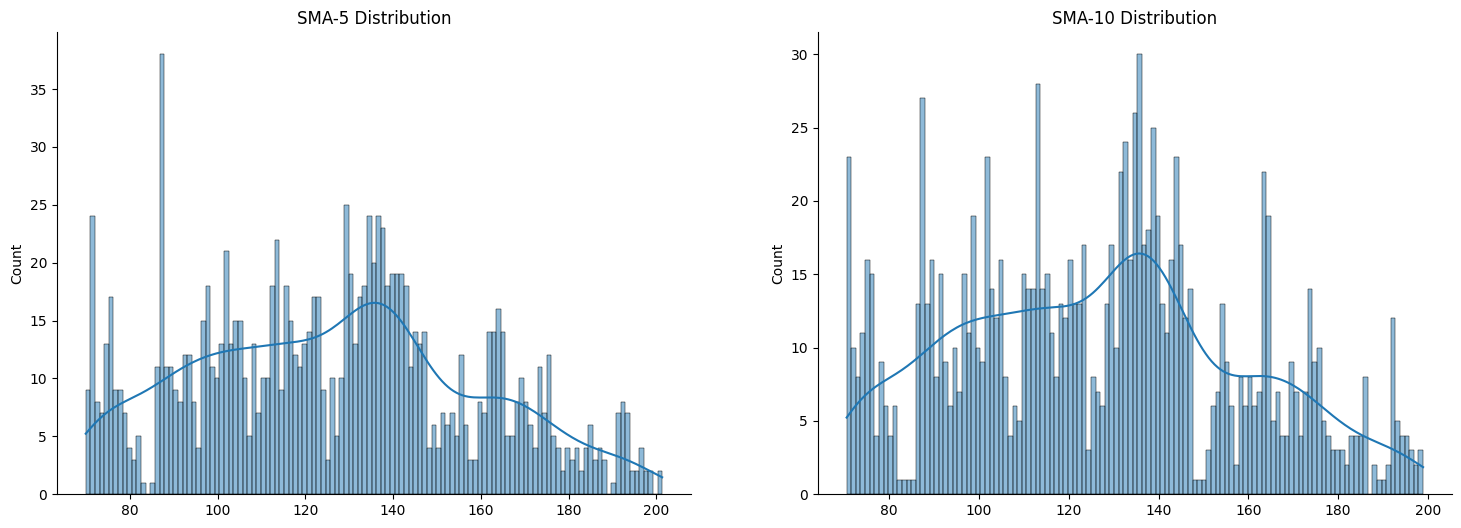

In [6]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.histplot(sma5, bins=125, ax=ax[0], kde=True)
ax[0].set_title('SMA-5 Distribution')
ax[0].set_xlabel(None)
sns.histplot(sma10, bins=125, ax=ax[1], kde=True)
ax[1].set_title('SMA-10 Distribution')
ax[1].set_xlabel(None)


sns.despine()
plt.show()

**Selecting 2 Stocks (AAPL & MSFT) to use as featurtes**

In [7]:
x = pd.concat([close[['AAPL', 'MSFT']], spy, sma5, sma10], axis=1)
x.columns = ['AAPL', 'MSFT', 'SPY', 'SMA5', 'SMA10'] # Changing the column names to more convenient ones

## 🛠️ Building a Preprocessing Pipeline

Using `sklearn`, I will build a pipeline that performs two preprocessing steps:

1. **Convert stock price features to log-returns** using the `MakeLogReturns` class.  
2. **Scale the simple moving averages** using `RobustScaler`.

In [8]:
class MakeLogReturns(BaseEstimator, TransformerMixin):
    def __init__ (self):
        super().__init__()

    def fit(self, x):
        return self

    def transform(self, x):
        return np.log(x / x.shift())

In [9]:
log_cols = [0, 1, 2]
sma_cols = [3,4]

preprocessor = ColumnTransformer([
    ('log_returns', MakeLogReturns(), log_cols),
    ('robust_scaler', RobustScaler(), sma_cols)
], verbose_feature_names_out=True)

pipeline = Pipeline([
    ('transformer', preprocessor)
])

In [10]:
y = np.log(y / y.shift())
preprocessed_x = pipeline.fit_transform(x)
col_names = x.columns
dates = x.index
x_df = pd.DataFrame(columns=col_names,
                   data=preprocessed_x,
                   index=dates).dropna().iloc[:-1]
y = y[y.index>='2020-06-03']

In [11]:
len(x_df), len(y)

(1245, 1245)

## 🛠️ Train-Test Split

A random split, as known, doesn't work for time series data.  
Let's build a simple function to manually split the data based on time order.

In [12]:
def timeseries_train_test_split(x, y, test_size=0.2):
    size = len(x)
    train_size = int(size*(1-test_size))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return x_train, x_test, y_train, y_test

In [13]:
x_train, x_test, y_train, y_test = timeseries_train_test_split(x_df, y)

# 🔬 Fitting the Model

Similarly to common libraries such as ***sklearn*** and ***statsmodels***, we can fit the model by calling the `fit` method.

> ♻️ **Note**:  
> Whenever you fit your model with a ***pandas DataFrame***, the class will automatically save your feature names and retrieve them in the summary.  
> If you use a ***NumPy array***, your OLS estimators will be marked as **{X₁... Xₙ}**.

In [14]:
fmols = FactorsModelOLS(fit_intercept=True)
fmols.fit(x_train, y_train)

INFO:root:Factors data type: <class 'pandas.core.frame.DataFrame'> was automatically converted into np.ndarray
INFO:root:Target data type: <class 'pandas.core.series.Series'> was automatically converted into np.ndarray
INFO:root:Model Fitted Successfully


## 🗒️ `summary`

The `summary` method is probably one of the most important functions provided by the `FactorsModelOLS` class.  
By calling this method, you will get a **pandas DataFrame** containing important information about each independent variable:

1. **Coefficient** – The OLS estimator value.
2. **Std** – The OLS estimator standard deviation.
3. **t-Statistic** – The OLS estimator t-statistic value, indicating the estimator's significance.
4. **p-Value** – The OLS estimator p-value, also indicating the estimator's significance.


In [15]:
fmols.summary()

,Coefficient,Std,t-Statistic,p-Value
Intercept,0.000862,0.000744,1.157822,0.247216
AAPL,-0.018503,0.053577,-0.345356,0.729900
MSFT,0.047413,0.059283,0.799783,0.424028
SPY,-0.095744,0.103583,-0.924317,0.355547
SMA5,-0.030678,0.014832,-2.068371,0.038864
SMA10,0.028756,0.014629,1.965709,0.049611


## 🖋️ Additional Properties

In case you are interested in accessing one of the summary columns independently,  
you can easily do that by calling its corresponding property:

- `.factors_weight` — Returns the OLS coefficients.
- `.residuals` — Returns the residuals vector.
- `.t_statistics` — Returns the t-statistic for each coefficient.
- `.p_values` — Returns the p-values for each coefficient.

In [16]:
fmols.factors_weights

array([ 0.00086182, -0.01850321,  0.04741321, -0.09574359, -0.03067798,
        0.02875557])

In [17]:
fmols.p_values

array([0.24721582, 0.72990001, 0.42402822, 0.35554672, 0.03886437,
       0.04961136])

In [18]:
fmols.t_statistics

array([ 1.15782228, -0.34535615,  0.79978329, -0.92431663, -2.06837086,
        1.96570936])

In [19]:
fmols.residuals[:10]

array([-0.00378813, -0.0182929 ,  0.01601522,  0.00524491,  0.00149009,
        0.00587034, -0.04790523,  0.00146602,  0.00416129,  0.01611956])

## 📈 `predict`

Similar to other common libraries, predictions are made by calling the `predict` method.  
After calling the `predict` method, you can easily evaluate the model's performance both visually and numerically.

In [20]:
y_pred = fmols.predict(x_test)
residuals = y_test - y_pred
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Residuals Mean: {residuals.mean()}')
print(f'MSE: {MSE}')
print(f'MAE: {MAE}')

Residuals Mean: 0.0004110620669492604
MSE: 0.0003882281932494738
MAE: 0.014664099362443384


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


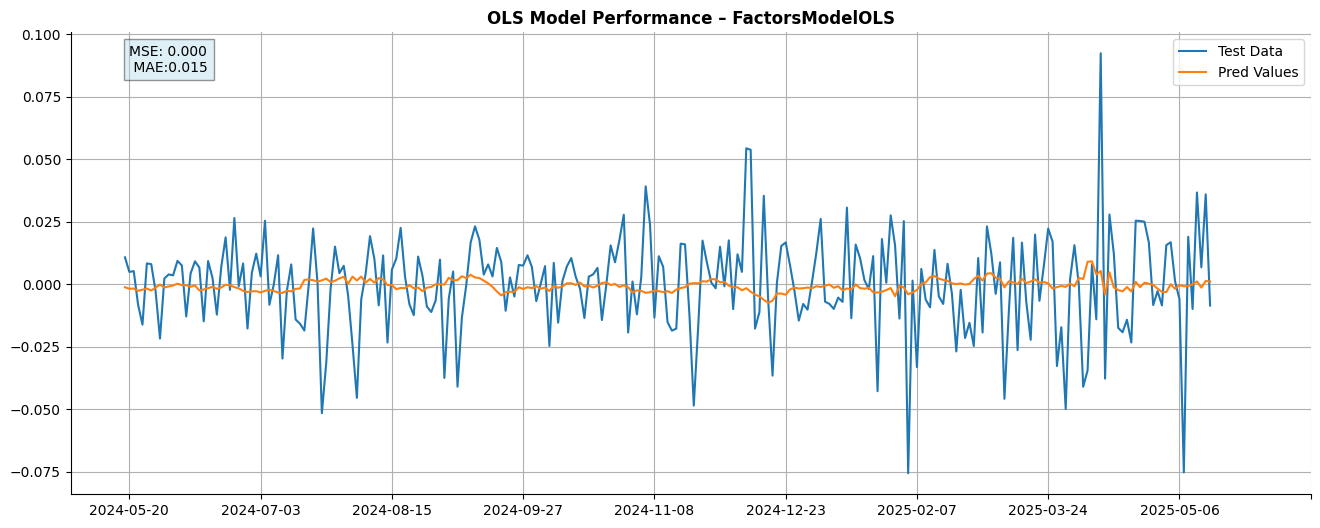

In [21]:
plt.figure(figsize=(16,6))

plt.plot(y_test, label='Test Data')
plt.plot(y_pred, label='Pred Values')
plt.xticks(range(1,300, 30))
plt.title('OLS Model Performance – FactorsModelOLS', weight='bold')
plt.text(x=1,
        y=0.085,
        s=f'MSE: {MSE:.3f}\n MAE:{MAE:.3f}',
        bbox={'facecolor': 'lightblue',
             'edgecolor':'k',
             'alpha': .4})
plt.legend()
plt.grid()
sns.despine()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


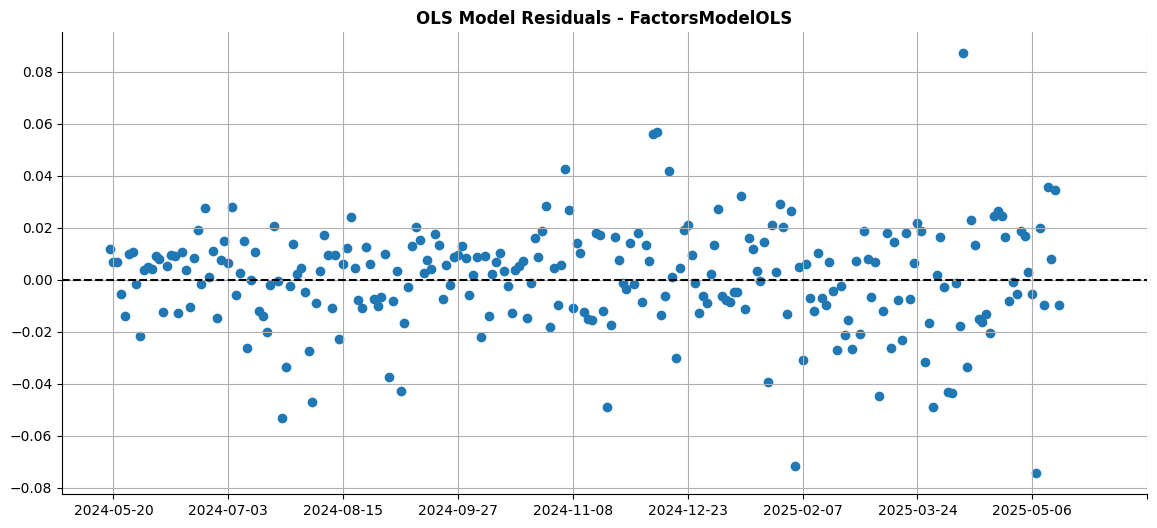

In [22]:
plt.figure(figsize=(14,6))
plt.scatter(y_test.index, y_test - y_pred)
plt.xticks(range(1,300,30))
plt.axhline(0, c='k', ls='--')
plt.title('OLS Model Residuals - FactorsModelOLS', weight='bold')
plt.grid()
sns.despine()
plt.show()